In [23]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from datapreprosessing import *


In [24]:
audio_dir='fma_small'

feature_extraction_test = extract_features('fma_small/000/000002.mp3')

filepath = 'fma_small/fma_metadata/tracks.csv'
tracks = load_tracks(filepath)
fma_small = tracks[tracks['set', 'subset'] == 'small']

# Print the shape of the small subset
print(fma_small.shape)

(8000, 52)


In [25]:
# Load X and y from the saved .npy files

XX = np.load('X.npy', allow_pickle=True)
yy = np.load('y.npy', allow_pickle=True)


In [26]:


# (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(XX, yy, test_size=0.2, random_state=42, stratify=yy)

# Check the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")



X_train shape: (6395, 328), y_train shape: (6395,)
X_test shape: (1599, 328), y_test shape: (1599,)


In [27]:


clf = RandomForestClassifier(n_estimators=500, min_samples_split=5, min_samples_leaf=1, bootstrap=True)

scores = cross_val_score(clf, X_train, y_train)
print(f"Cross-validation accuracy: {scores.mean():.4f}")
#Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
clf.fit(X_train, y_train)


Cross-validation accuracy: 0.5165


RandomForestClassifier(min_samples_split=5, n_estimators=500)

In [28]:
# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 52.10%
Classification Report:
               precision    recall  f1-score   support

   Electronic       0.50      0.53      0.51       200
 Experimental       0.56      0.35      0.43       200
         Folk       0.63      0.68      0.65       200
      Hip-Hop       0.53      0.62      0.57       199
 Instrumental       0.56      0.64      0.60       200
International       0.58      0.54      0.56       200
          Pop       0.29      0.23      0.26       200
         Rock       0.48      0.58      0.53       200

     accuracy                           0.52      1599
    macro avg       0.52      0.52      0.51      1599
 weighted avg       0.52      0.52      0.51      1599



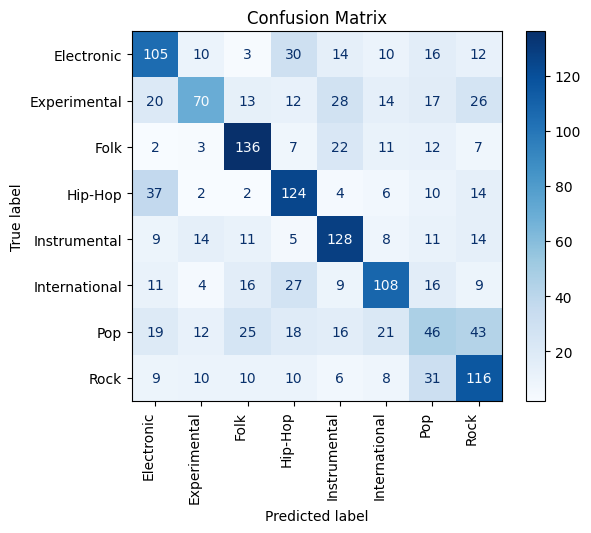

In [29]:


conf_matrix = confusion_matrix(y_test, y_pred)

class_names = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International',  'Pop', 'Rock']
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)

disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90, ha='right')
plt.title("Confusion Matrix")
plt.show()


In [33]:
from joblib import dump
# Save model
dump(clf, 'models/rf_model.joblib')

['models/rf_model.joblib']

In [37]:
def classify_genre(audio_path):
    
    features = extract_features(audio_path) 
    features = features.reshape(1, -1)
    genre= clf.predict(features)[0]
    return genre

d = classify_genre('fma_small/000/000002.mp3')
print(d)

Hip-Hop
